In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-cancer-gene-expression-cumida/Breast_GSE45827.csv


/kaggle/input/breast-cancer-gene-expression-cumida/Breast_GSE45827.csv
Raw shape: (151, 54677)
First columns: ['samples', 'type', '1007_s_at', '1053_at', '117_at', '121_at']
Dropped 'samples' column.

Feature matrix: (151, 54675)
Data types: [dtype('float64')]
Any nulls: False

Class distribution:
type
basal        41
HER          30
luminal_B    30
luminal_A    29
cell_line    14
normal        7
Name: count, dtype: int64

Class → color mapping: {'HER': '#E53935', 'basal': '#FF9800', 'cell_line': '#4CAF50', 'luminal_A': '#2196F3', 'luminal_B': '#9C27B0', 'normal': '#795548'}


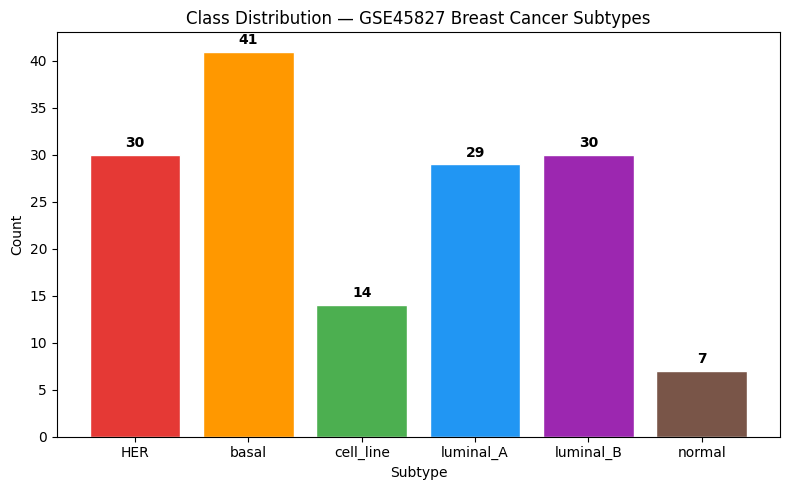

After variance filter (thresh=0.5): (151, 11715)
Scaled — mean: -0.0000, std: 1.0000


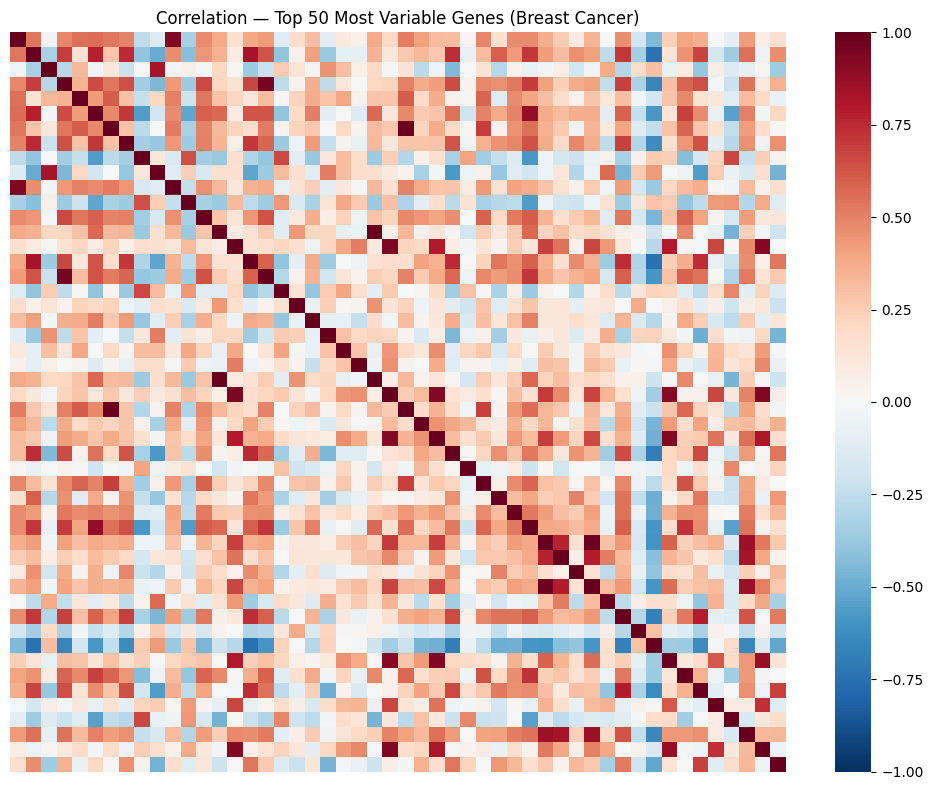

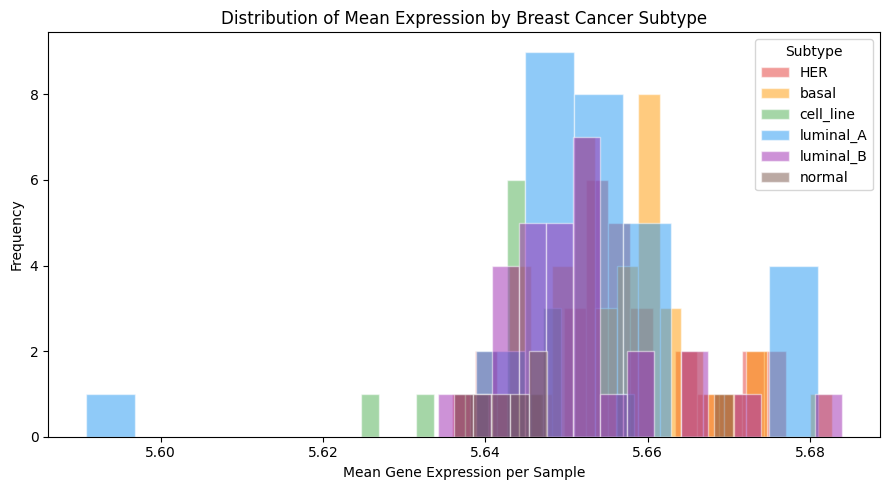


PCA — variance explained:
  PC1: 17.8%  (cumulative: 17.8%)
  PC2: 10.3%  (cumulative: 28.2%)
  PC3: 6.7%  (cumulative: 34.9%)
  PC4: 4.5%  (cumulative: 39.4%)
  PC5: 3.4%  (cumulative: 42.7%)
  PC6: 2.9%  (cumulative: 45.6%)
  PC7: 2.3%  (cumulative: 47.9%)
  PC8: 2.1%  (cumulative: 50.0%)
  PC9: 1.6%  (cumulative: 51.6%)
  PC10: 1.3%  (cumulative: 52.9%)


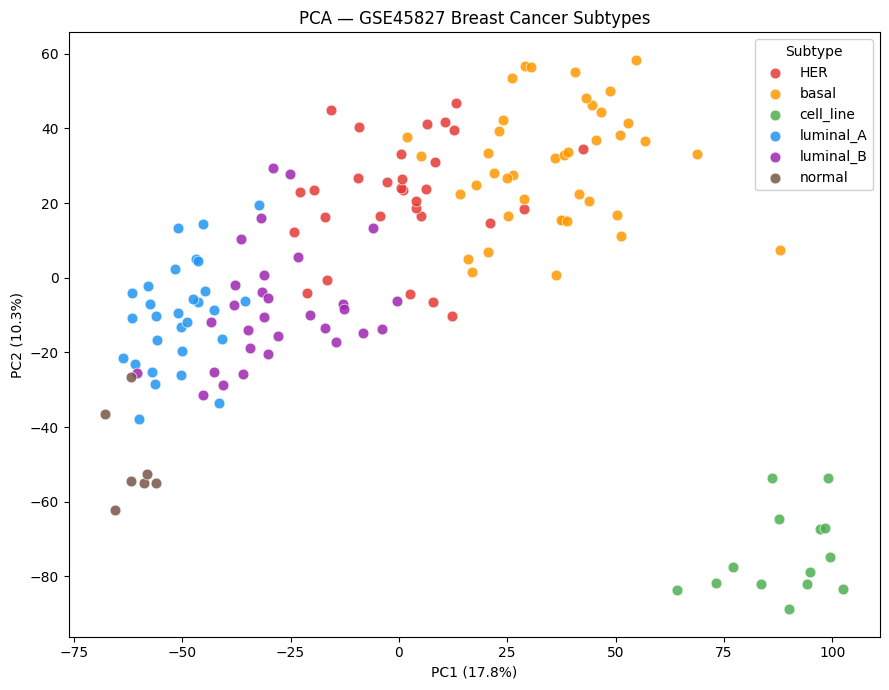

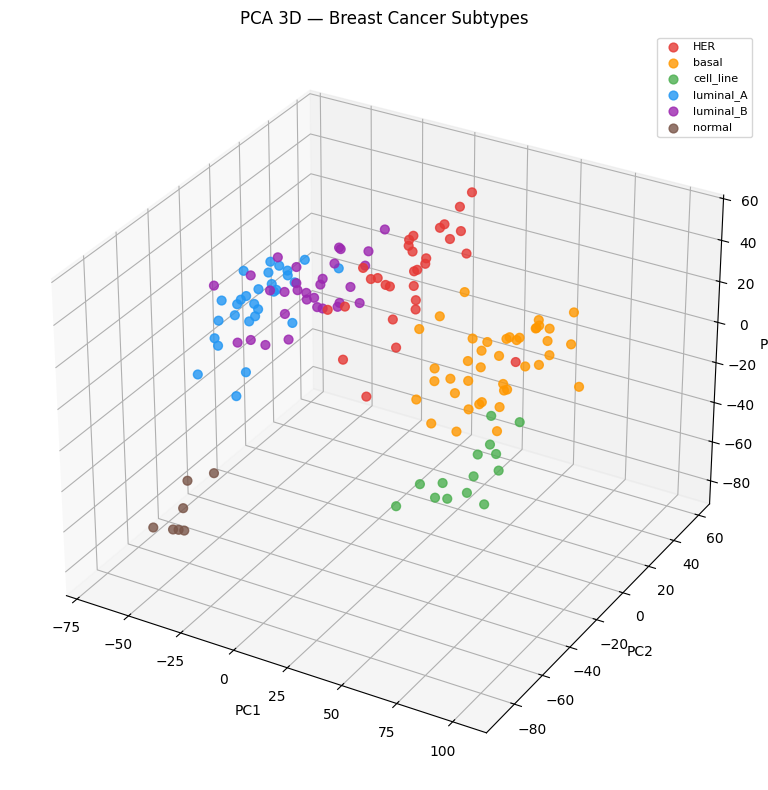


Computing hierarchical clustering (Ward)...


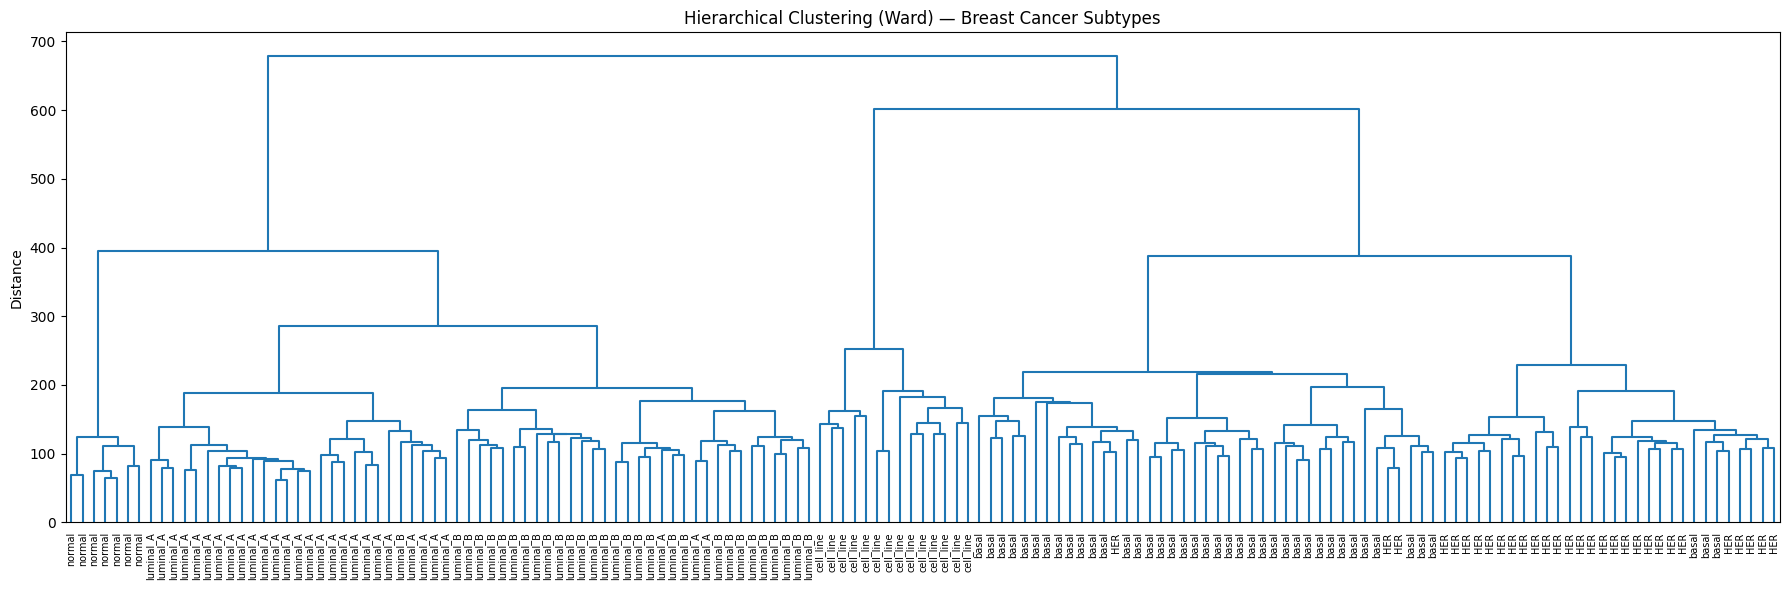


K-Means (k=6) — Adjusted Rand Index: 0.726

Cross-tabulation:
Cluster     0   1   2   3   4  5
True                            
HER         1   4   0  25   0  0
basal      37   0   0   4   0  0
cell_line   0   0   0   0  14  0
luminal_A   0   1  28   0   0  0
luminal_B   0  22   6   2   0  0
normal      0   0   0   0   0  7
Selected 100 top discriminating genes via ANOVA F-test


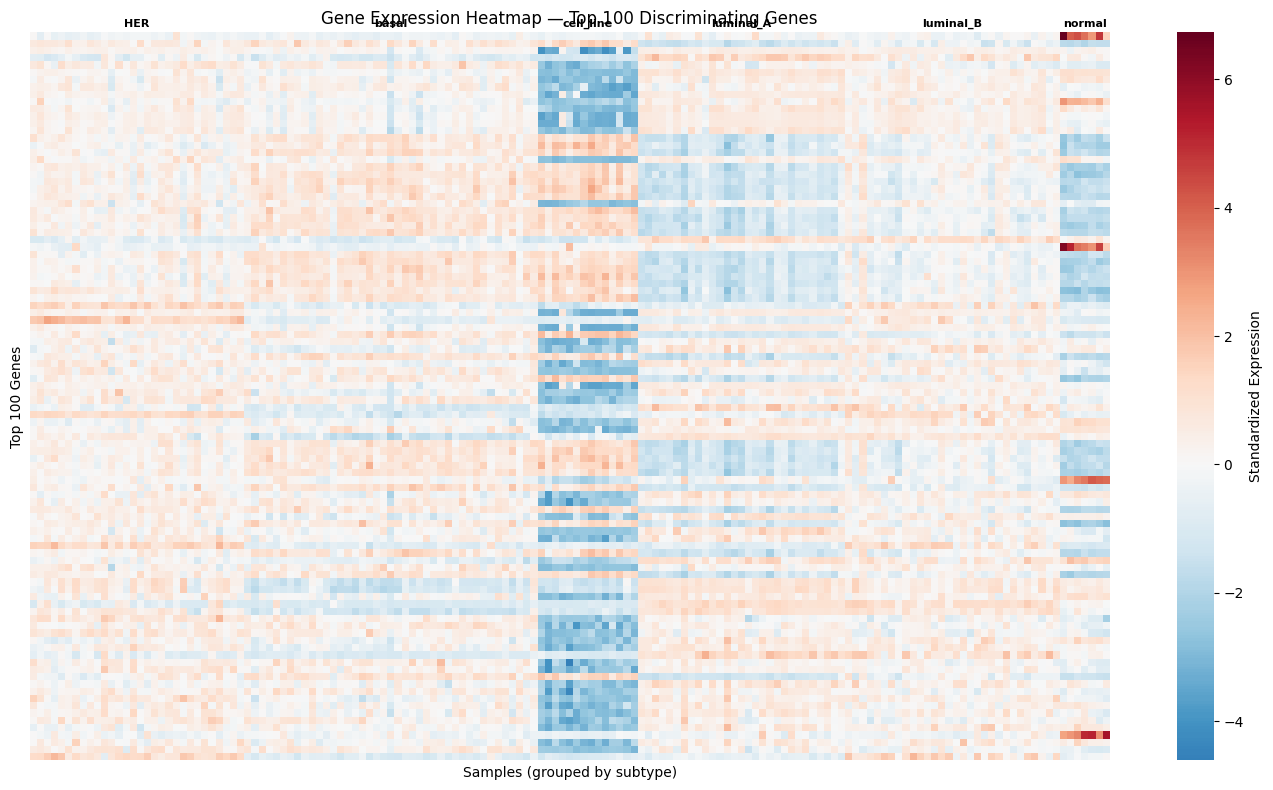

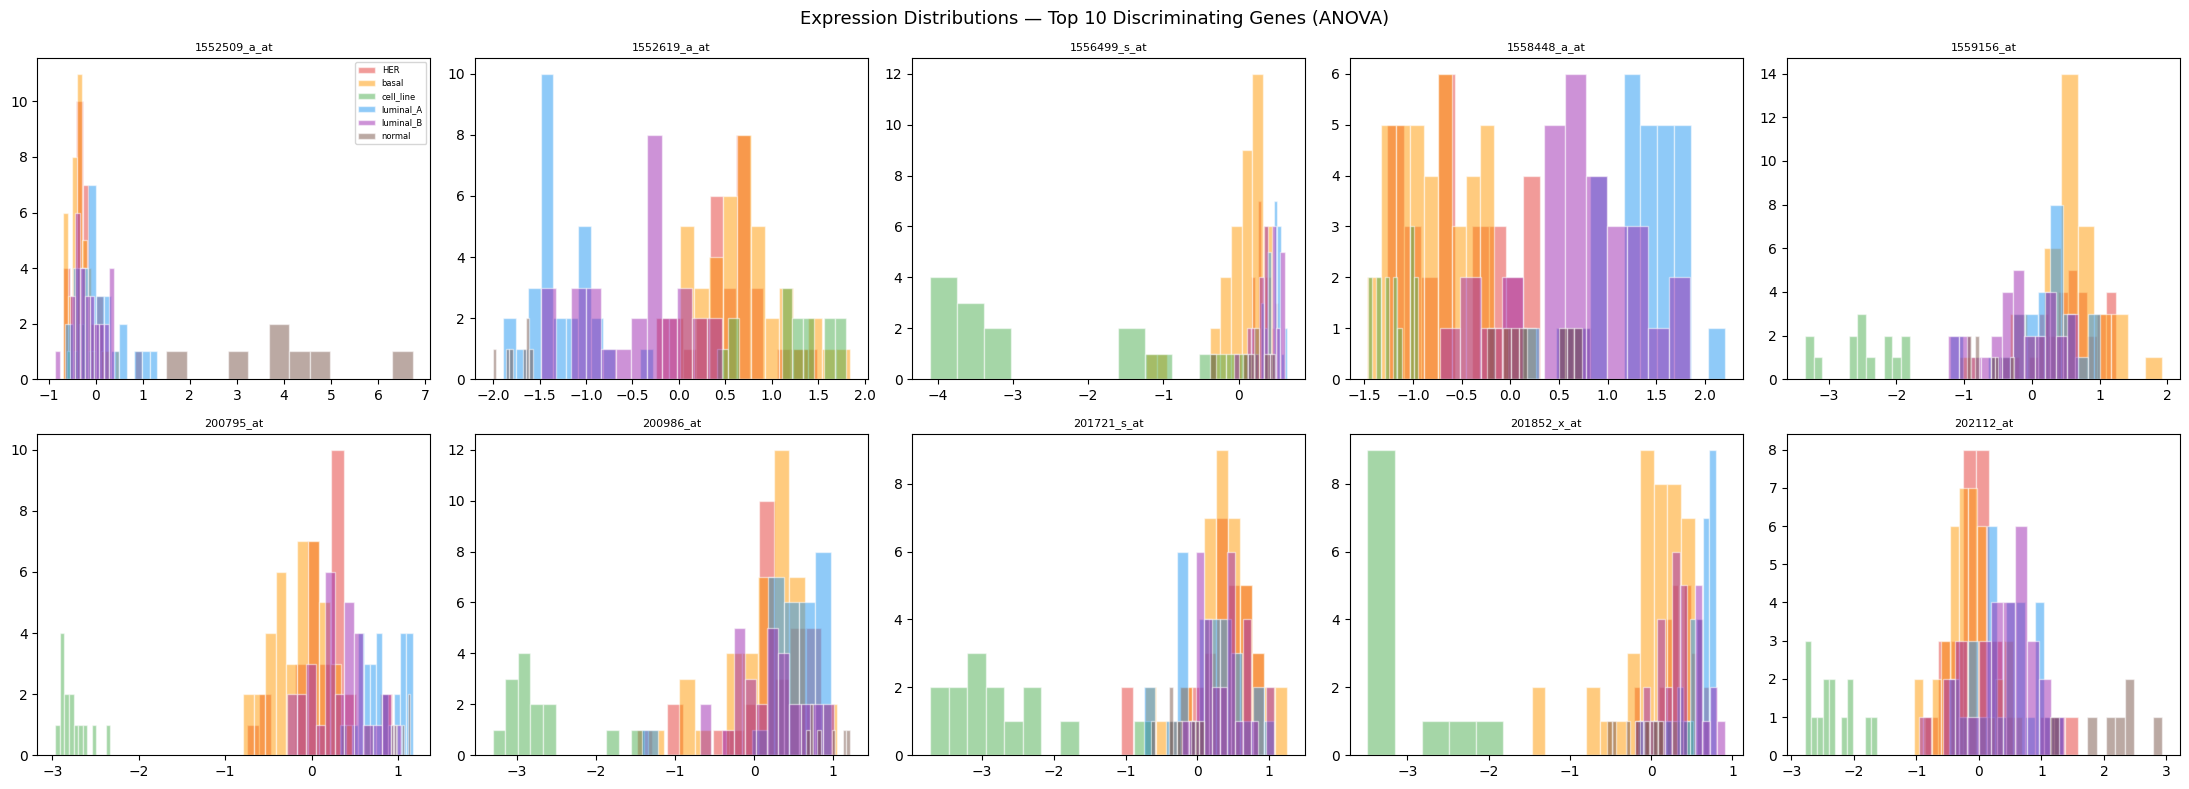

STRATIFIED 5-FOLD CV — BREAST CANCER SUBTYPES
  Nearest Centroid         : 0.927 ± 0.039
  Logistic Regression      : 0.927 ± 0.049
  Linear SVM               : 0.960 ± 0.024
  RBF SVM                  : 0.947 ± 0.040
  Random Forest            : 0.954 ± 0.040
  KNN (k=5)                : 0.867 ± 0.043
  Gradient Boosting        : 0.834 ± 0.099

Running GridSearchCV — Logistic Regression Pipeline...

GRID SEARCH — Logistic Regression Pipeline
Best Parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'pca__n_components': 10}
Best CV Accuracy: 0.9469

Running GridSearchCV — SVM Pipeline...

GRID SEARCH — SVM Pipeline
Best Parameters: {'classifier__C': 0.1, 'classifier__kernel': 'linear', 'selector__k': 200}
Best CV Accuracy: 0.9867

CLASSIFICATION REPORT (CV predictions, best SVM config)
              precision    recall  f1-score   support

         HER       1.00      0.93      0.97        30
       basal       0.98      1.00      0.99        41
   cell_line       1.00      

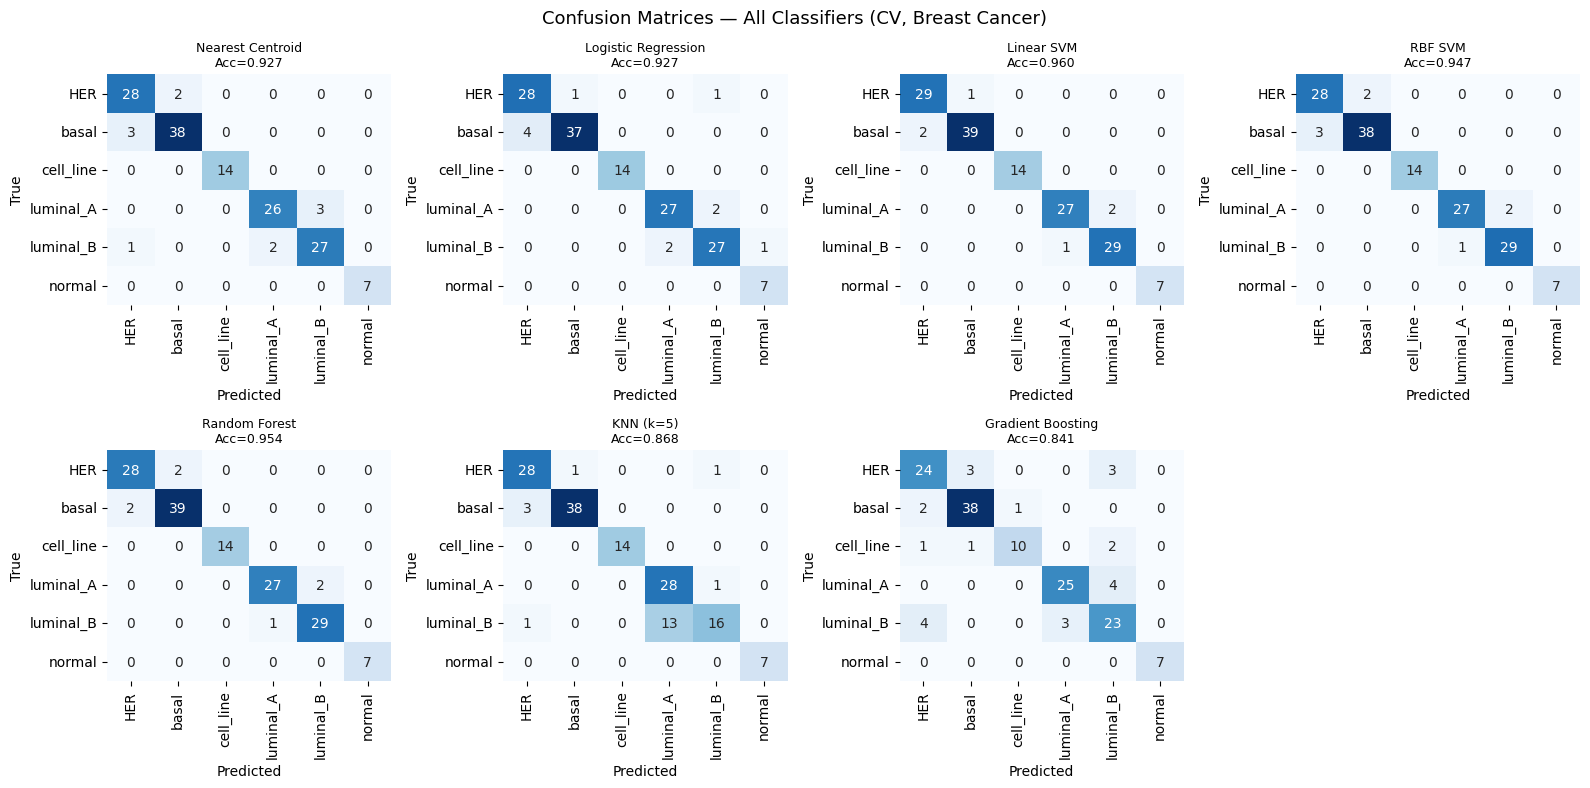

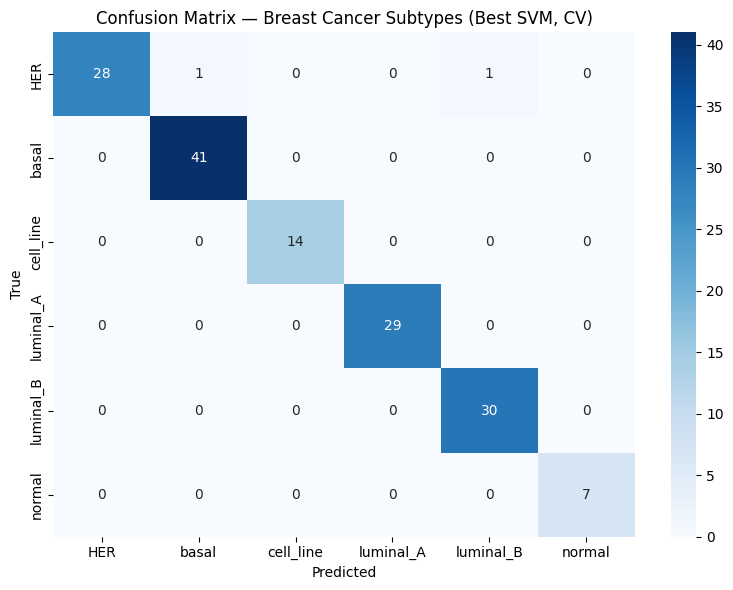

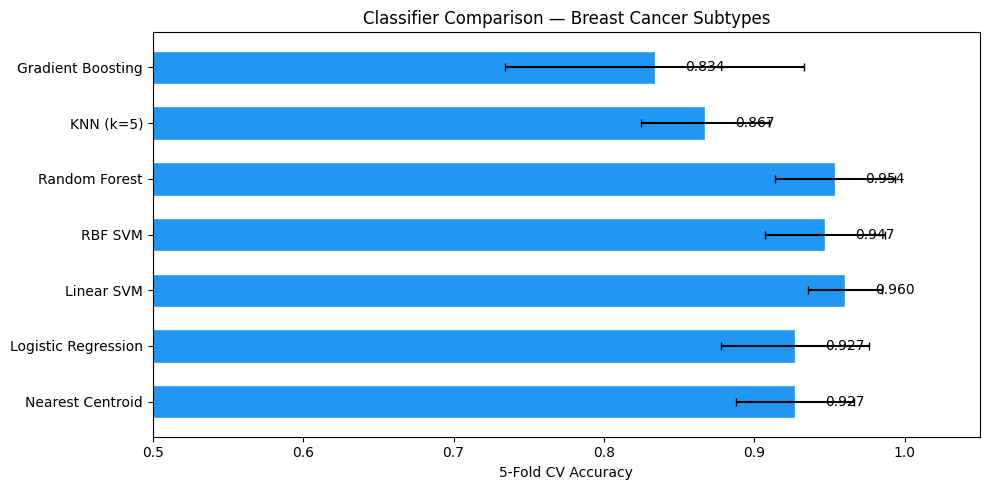

Per-class metrics (sorted by F1):
           precision    recall  f1-score  support
HER         1.000000  0.933333  0.965517     30.0
luminal_B   0.967742  1.000000  0.983607     30.0
basal       0.976190  1.000000  0.987952     41.0
cell_line   1.000000  1.000000  1.000000     14.0
luminal_A   1.000000  1.000000  1.000000     29.0
normal      1.000000  1.000000  1.000000      7.0

✅ Phase 2 complete. 11 figures rendered.
Variables preserved: results_cv, comparison_df, pipeline_configs, X_vt, y, y_pred_cv
Grid search best params — LR: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'pca__n_components': 10}
Grid search best params — SVM: {'classifier__C': 0.1, 'classifier__kernel': 'linear', 'selector__k': 200}


In [2]:
%matplotlib inline

# ============================================================
# Phase 2 — Breast Cancer Subtype Classification (GSE45827)
# ============================================================
# Apply the identical ML pipeline from Phase 1 (Golub leukemia)
# to GSE45827 breast cancer subtypes — a 6-class problem.
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import (
    StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV,
)
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, adjusted_rand_score,
)
from scipy.cluster.hierarchy import dendrogram, linkage
from mpl_toolkits.mplot3d import Axes3D

import warnings, os
warnings.filterwarnings("ignore")

# ── Discover input files (Kaggle style) ──────────────────────────────────────
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# ============================================================
# STEP 8: Data Loading
# ============================================================

DATA_PATH = "/kaggle/input/breast-cancer-gene-expression-cumida/Breast_GSE45827.csv"
df = pd.read_csv(DATA_PATH)
print(f"Raw shape: {df.shape}")
print(f"First columns: {list(df.columns[:6])}")

if "samples" in df.columns:
    df = df.drop(columns=["samples"])
    print("Dropped 'samples' column.")

y = df["type"]
X = df.drop(columns=["type"])

print(f"\nFeature matrix: {X.shape}")
print(f"Data types: {X.dtypes.unique()}")
print(f"Any nulls: {X.isnull().any().any()}")
print(f"\nClass distribution:\n{y.value_counts()}")

BASE_COLORS = ["#E53935", "#FF9800", "#4CAF50", "#2196F3", "#9C27B0", "#795548"]
sorted_labels = sorted(y.unique())
CLASS_COLORS = {label: BASE_COLORS[i] for i, label in enumerate(sorted_labels)}
print(f"\nClass → color mapping: {CLASS_COLORS}")

# --- 8b. Class distribution plot ---
fig, ax = plt.subplots(figsize=(8, 5))
counts = y.value_counts().loc[sorted_labels]
bars = ax.bar(counts.index, counts.values,
              color=[CLASS_COLORS[l] for l in counts.index],
              edgecolor="white")
ax.set_ylabel("Count")
ax.set_xlabel("Subtype")
ax.set_title("Class Distribution — GSE45827 Breast Cancer Subtypes")
for bar, v in zip(bars, counts.values):
    ax.text(bar.get_x() + bar.get_width() / 2, v + 0.5,
            str(v), ha="center", va="bottom", fontsize=10, fontweight="bold")
plt.tight_layout()
plt.show()

# ============================================================
# STEP 9: Preprocessing
# ============================================================

vt = VarianceThreshold(threshold=0.5)
X_vt = pd.DataFrame(
    vt.fit_transform(X),
    index=X.index,
    columns=X.columns[vt.get_support()],
)
print(f"After variance filter (thresh=0.5): {X_vt.shape}")

scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_vt),
    index=X_vt.index,
    columns=X_vt.columns,
)
print(f"Scaled — mean: {X_scaled.values.mean():.4f}, std: {X_scaled.values.std():.4f}")

# --- 9c. Correlation heatmap — top 50 most variable genes ---
gene_var = X_vt.var(axis=0)
top_50_var = gene_var.nlargest(50).index

plt.figure(figsize=(10, 8))
sns.heatmap(X_vt[top_50_var].corr(), cmap="RdBu_r", center=0,
            vmin=-1, vmax=1, xticklabels=False, yticklabels=False)
plt.title("Correlation — Top 50 Most Variable Genes (Breast Cancer)")
plt.tight_layout()
plt.show()

# --- 9d. Expression distribution per subtype ---
fig, ax = plt.subplots(figsize=(9, 5))
for label in sorted_labels:
    means = X.loc[y == label].mean(axis=1)
    ax.hist(means, bins=15, alpha=0.5, color=CLASS_COLORS[label],
            label=label, edgecolor="white")
ax.set_xlabel("Mean Gene Expression per Sample")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Mean Expression by Breast Cancer Subtype")
ax.legend(title="Subtype")
plt.tight_layout()
plt.show()

# ============================================================
# STEP 10: Unsupervised Analysis
# ============================================================

# --- 10a. PCA (2D and 3D) ---
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

print("\nPCA — variance explained:")
cumulative = 0.0
for i in range(min(10, len(pca.explained_variance_ratio_))):
    cumulative += pca.explained_variance_ratio_[i] * 100
    print(f"  PC{i+1}: {pca.explained_variance_ratio_[i]*100:.1f}%  (cumulative: {cumulative:.1f}%)")

# 2D scatter
fig, ax = plt.subplots(figsize=(9, 7))
for label in sorted_labels:
    mask = y == label
    ax.scatter(
        X_pca[mask, 0], X_pca[mask, 1],
        c=CLASS_COLORS[label], label=label, s=60,
        edgecolors="white", linewidth=0.5, alpha=0.85,
    )
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_title("PCA — GSE45827 Breast Cancer Subtypes")
ax.legend(title="Subtype", framealpha=0.9)
plt.tight_layout()
plt.show()

# 3D scatter
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
for label in sorted_labels:
    mask = y == label
    ax.scatter(
        X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2],
        c=CLASS_COLORS[label], label=label, s=40, alpha=0.8,
    )
ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
ax.set_title("PCA 3D — Breast Cancer Subtypes")
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

# --- 10b. Hierarchical Clustering ---
print("\nComputing hierarchical clustering (Ward)...")
linkage_matrix = linkage(X_scaled.values, method="ward", metric="euclidean")

plt.figure(figsize=(18, 6))
dendrogram(
    linkage_matrix,
    labels=y.values,
    leaf_rotation=90,
    leaf_font_size=7,
    color_threshold=0,
)
plt.title("Hierarchical Clustering (Ward) — Breast Cancer Subtypes")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# --- 10c. K-Means (k=6) + Adjusted Rand Index ---
n_classes = y.nunique()
kmeans = KMeans(n_clusters=n_classes, n_init=50, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

le = LabelEncoder()
y_encoded = le.fit_transform(y)
ari = adjusted_rand_score(y_encoded, clusters)
print(f"\nK-Means (k={n_classes}) — Adjusted Rand Index: {ari:.3f}")

ct = pd.crosstab(y, clusters, rownames=["True"], colnames=["Cluster"])
print(f"\nCross-tabulation:\n{ct}")

# ============================================================
# STEP 11: Feature Selection (ANOVA top-100)
# ============================================================

selector = SelectKBest(f_classif, k=100)
selector.fit(X_scaled, y)

top_100_genes = X_scaled.columns[selector.get_support()].tolist()
X_selected = X_scaled[top_100_genes]
print(f"Selected {len(top_100_genes)} top discriminating genes via ANOVA F-test")

# Heatmap — samples grouped by subtype
sort_idx = y.sort_values().index
X_heatmap = X_selected.loc[sort_idx]

plt.figure(figsize=(14, 8))
sns.heatmap(
    X_heatmap.T, cmap="RdBu_r", center=0,
    xticklabels=False, yticklabels=False,
    cbar_kws={"label": "Standardized Expression"},
)

sorted_y = y.loc[sort_idx]
prev = 0
for label in sorted_y.unique():
    count = (sorted_y == label).sum()
    mid = prev + count / 2
    plt.text(mid, -0.5, label, ha="center", va="bottom", fontsize=8, fontweight="bold")
    prev += count

plt.xlabel("Samples (grouped by subtype)")
plt.ylabel("Top 100 Genes")
plt.title("Gene Expression Heatmap — Top 100 Discriminating Genes")
plt.tight_layout()
plt.show()

# --- 11b. Top 10 gene expression distributions by subtype ---
top_10_genes = X_scaled.columns[selector.get_support()].tolist()[:10]

fig, axes = plt.subplots(2, 5, figsize=(22, 8))
for i, gene in enumerate(top_10_genes):
    ax = axes[i // 5][i % 5]
    for label in sorted_labels:
        ax.hist(X_scaled.loc[y == label, gene], bins=12,
                alpha=0.5, color=CLASS_COLORS[label],
                label=label, edgecolor="white")
    ax.set_title(gene, fontsize=8)
    if i == 0:
        ax.legend(fontsize=6)

plt.suptitle("Expression Distributions — Top 10 Discriminating Genes (ANOVA)", fontsize=13)
plt.tight_layout()
plt.show()

# ============================================================
# STEP 12: Supervised Classification
# ============================================================

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipeline_configs = {
    "Nearest Centroid": Pipeline([
        ("scaler", StandardScaler()),
        ("classifier", NearestCentroid()),
    ]),
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
        ("classifier", LogisticRegression(solver="liblinear", max_iter=5000)),
    ]),
    "Linear SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("classifier", SVC(kernel="linear", random_state=42)),
    ]),
    "RBF SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("classifier", SVC(kernel="rbf", random_state=42)),
    ]),
    "Random Forest": Pipeline([
        ("scaler", StandardScaler()),
        ("classifier", RandomForestClassifier(n_estimators=100, random_state=42)),
    ]),
    "KNN (k=5)": Pipeline([
        ("scaler", StandardScaler()),
        ("classifier", KNeighborsClassifier(n_neighbors=5)),
    ]),
    "Gradient Boosting": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=50)),
        ("classifier", GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ]),
}

results_cv = {}
print("=" * 60)
print("STRATIFIED 5-FOLD CV — BREAST CANCER SUBTYPES")
print("=" * 60)

for name, pipe in pipeline_configs.items():
    scores = cross_val_score(pipe, X_vt, y, cv=cv, scoring="accuracy")
    results_cv[name] = {"mean": scores.mean(), "std": scores.std()}
    print(f"  {name:25s}: {scores.mean():.3f} ± {scores.std():.3f}")

# --- 12b. GridSearchCV — Logistic Regression Pipeline ---
print("\nRunning GridSearchCV — Logistic Regression Pipeline...")

pipeline_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),
    ("classifier", LogisticRegression(solver="liblinear", max_iter=5000)),
])

param_grid_lr = {
    "pca__n_components": [10, 20, 30, 50],
    "classifier__C": [0.01, 0.1, 1, 10],
    "classifier__penalty": ["l1", "l2"],
}

grid_lr = GridSearchCV(
    pipeline_lr, param_grid_lr, cv=cv, scoring="accuracy", n_jobs=-1,
)
grid_lr.fit(X_vt, y)

print("\n" + "=" * 60)
print("GRID SEARCH — Logistic Regression Pipeline")
print("=" * 60)
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Best CV Accuracy: {grid_lr.best_score_:.4f}")

# --- 12c. GridSearchCV — SVM Pipeline ---
print("\nRunning GridSearchCV — SVM Pipeline...")

pipeline_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("selector", SelectKBest(f_classif)),
    ("classifier", SVC(random_state=42)),
])

param_grid_svm = {
    "selector__k": [50, 100, 200],
    "classifier__C": [0.1, 1, 10],
    "classifier__kernel": ["linear", "rbf"],
}

grid_svm = GridSearchCV(
    pipeline_svm, param_grid_svm, cv=cv, scoring="accuracy", n_jobs=-1,
)
grid_svm.fit(X_vt, y)

print("\n" + "=" * 60)
print("GRID SEARCH — SVM Pipeline")
print("=" * 60)
print(f"Best Parameters: {grid_svm.best_params_}")
print(f"Best CV Accuracy: {grid_svm.best_score_:.4f}")

# --- 12d. Per-class Classification Report (best SVM model) ---
best_clf = grid_svm.best_estimator_
y_pred_cv = cross_val_predict(best_clf, X_vt, y, cv=cv)

print("\n" + "=" * 60)
print("CLASSIFICATION REPORT (CV predictions, best SVM config)")
print("=" * 60)
print(classification_report(y, y_pred_cv, zero_division=0))

# ============================================================
# STEP 13: Evaluation
# ============================================================

# --- 13a. Confusion Matrices — All Classifiers ---
n_clf = len(pipeline_configs)
n_cols = 4
n_rows = (n_clf + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes_flat = axes.flatten()

for i, (name, pipe) in enumerate(pipeline_configs.items()):
    y_pred_all = cross_val_predict(pipe, X_vt, y, cv=cv)
    cm = confusion_matrix(y, y_pred_all, labels=sorted_labels)
    acc = accuracy_score(y, y_pred_all)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=sorted_labels, yticklabels=sorted_labels,
                ax=axes_flat[i], cbar=False)
    axes_flat[i].set_title(f"{name}\nAcc={acc:.3f}", fontsize=9)
    axes_flat[i].set_xlabel("Predicted")
    axes_flat[i].set_ylabel("True")

for j in range(i + 1, len(axes_flat)):
    axes_flat[j].axis("off")

plt.suptitle("Confusion Matrices — All Classifiers (CV, Breast Cancer)", fontsize=13)
plt.tight_layout()
plt.show()

# --- 13b. Confusion Matrix Heatmap — Best SVM ---
cm = confusion_matrix(y, y_pred_cv, labels=sorted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=sorted_labels,
    yticklabels=sorted_labels,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Breast Cancer Subtypes (Best SVM, CV)")
plt.tight_layout()
plt.show()

# --- 13c. Per-Classifier Accuracy Bar Chart ---
fig, ax = plt.subplots(figsize=(10, 5))
names = list(results_cv.keys())
means = [results_cv[n]["mean"] for n in names]
stds = [results_cv[n]["std"] for n in names]

bars = ax.barh(names, means, xerr=stds, color="#2196F3",
               edgecolor="white", height=0.6, capsize=3)
ax.set_xlim(0.5, 1.05)
ax.set_xlabel("5-Fold CV Accuracy")
ax.set_title("Classifier Comparison — Breast Cancer Subtypes")

for bar, m in zip(bars, means):
    ax.text(m + 0.02, bar.get_y() + bar.get_height() / 2,
            f"{m:.3f}", va="center", fontsize=10)

plt.tight_layout()
plt.show()

# --- 13d. Identify Hardest Subtypes ---
report = classification_report(y, y_pred_cv, output_dict=True, zero_division=0)
per_class = {k: v for k, v in report.items() if k in y.unique()}

f1_df = pd.DataFrame(per_class).T[["precision", "recall", "f1-score", "support"]]
f1_df = f1_df.sort_values("f1-score")
print("Per-class metrics (sorted by F1):")
print(f1_df.to_string())

# ============================================================
# Phase 2 Summary (variables preserved for Phase 3)
# ============================================================
comparison_df = pd.DataFrame(results_cv).T
comparison_df.columns = ["cv_mean_accuracy", "cv_std_accuracy"]
comparison_df = comparison_df.sort_values("cv_mean_accuracy", ascending=False)

print("\n✅ Phase 2 complete. 11 figures rendered.")
print(f"Variables preserved: results_cv, comparison_df, pipeline_configs, X_vt, y, y_pred_cv")
print(f"Grid search best params — LR: {grid_lr.best_params_}")
print(f"Grid search best params — SVM: {grid_svm.best_params_}")